In [1]:
%load_ext memory_profiler
%load_ext memray
import abtem
import dask
import numpy as np
from ase.cluster import Decahedron
from bokeh.io import output_notebook
from bokeh.layouts import row
from dask.distributed import Client

output_notebook()

Loading BokehJS ...

In [2]:
gpts = 512
sampling = 0.05
num_configs = 8
threads = 1

abtem.config.set(fft="mkl")

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='x [Å]', ylabel='y [Å]'>)

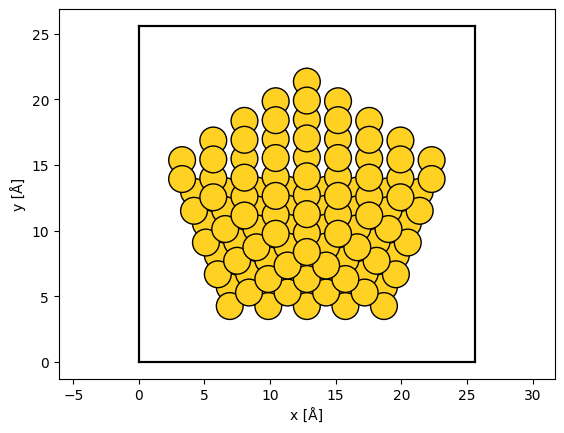

In [3]:
extent = gpts * sampling
slope = 0.19908323698251337

p = int(np.floor(slope * extent))
q = max(p // 4, 2)

atoms = Decahedron("Au", p, q, 0)
atoms.rotate("x", 30)
atoms.cell[0, 0] = atoms.cell[1, 1] = extent
atoms.center()
atoms.center(axis=2, vacuum=4)

abtem.show_atoms(atoms)

In [4]:
interpolation = gpts // 256

In [5]:
#client = Client()
#client

In [64]:
frozen_phonons = abtem.FrozenPhonons(atoms, num_configs=1, sigmas=0.0)

potential = abtem.Potential(
    frozen_phonons, gpts=gpts, slice_thickness=20, projection="infinite"
)

s_matrix = abtem.SMatrix(
    potential=None,
    energy=100e3,
    semiangle_cutoff=20,
    downsample=True,
    extent=(10,10),
    gpts=(100,200),
    interpolation=1,
)

detector = abtem.AnnularDetector(inner=80, outer=240)
detector = abtem.PixelatedDetector()
detector = abtem.FlexibleAnnularDetector()

scan = abtem.GridScan()

s_matrix.cutoff_angles

(122.14740763917032, 122.14740763917032)

In [60]:
s_matrix.build().dummy_probes().metadata

{'energy': 100000.0,
 'adjusted_antialias_cutoff_gpts': (66, 66),
 'semiangle_cutoff': 20,
 'base_tilt_x': 0.0,
 'base_tilt_y': 0.0}

In [62]:
s_matrix.antialias_valid_gpts

(46, 46)

In [65]:
measurements = s_matrix.scan(
    lazy=False, detectors=detector, scan=scan
)
#measurements.compute().shape

(<PolarAxesSubplot: >, <matplotlib.collections.QuadMesh at 0x7fa605d0f8e0>)

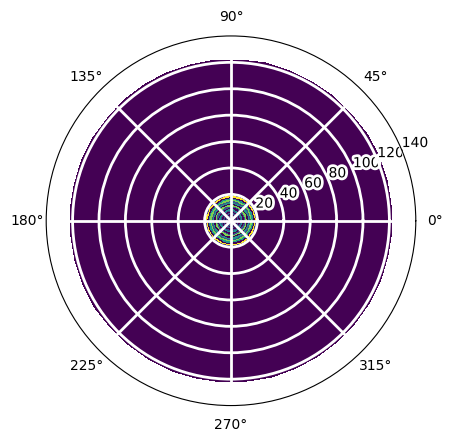

In [66]:
measurements.show()

In [201]:
#s_matrix.dummy_probes().metadata

In [202]:
#s_matrix.dummy_probes().antialias_cutoff_gpts

In [210]:
#s_matrix.dummy_probes()._gpts_within_angle("valid")

(60, 30)

In [204]:
#detector.measurement_shape(s_matrix.dummy_probes())

Unexpected exception formatting exception. Falling back to standard exception


2022-12-28 18:20:36,598 - distributed.worker - WARNING - Compute Failed
Key:       ('blocks-build_s_matrix-lazy_reduce-mean_chunk-pad-mean_agg-aggregate-fa5c7e71c49bc4efc67d99051d4935e8', 0, 0, 0, 0)
Function:  execute_task
args:      ((functools.partial(<function mean_agg at 0x7fe5e01bfaf0>, dtype=dtype('float32'), axis=(), keepdims=False), (subgraph_callable-4f82cf66-6aa2-4729-b469-f190e2a72ef7, (subgraph_callable-5ef7c50d-335d-4044-83c8-a02db4d9dfe4, (<function concatenate_axes at 0x7fe5e005d550>, [(subgraph_callable-20860a28-704d-43cb-ad23-56197d63ad93, (subgraph_callable-e386beca-ead0-4e05-9c35-d148a60bcec0, (<function concatenate_axes at 0x7fe5e005d550>, [array([<abtem.prism.s_matrix.SMatrix object at 0x7fe5e34d0eb0>],
      dtype=object)], [0]), array([[[(0, 61)]]], dtype=object)))], [0])), 0)))
kwargs:    {}
Exception: "ValueError('could not broadcast input array from shape (22,11,60,60) into shape (22,11,60,42)')"

Traceback (most recent call last):
  File "/opt/anaconda3/envs

In [142]:
%%time
measurements.compute()

CPU times: user 59.7 ms, sys: 9.12 ms, total: 68.8 ms
Wall time: 186 ms


In [254]:
measurements.array.shape

(28, 28, 170, 170)

In [240]:
measurements.show()  # .shape

IndexError: list index out of range

In [47]:
#%%time
measurements = s_matrix.scan(
    lazy=False, detectors=detector
)  # .compute(scheduler="single-threaded")

# arr.compute(scheduler="single-threaded");

In [48]:
measurements.show()

(1, 28, 28)

In [46]:
%%time
measurements = s_matrix.scan(lazy=True, detectors=detector).compute()

[########################################] | 100% Completed | 24.08 ss
CPU times: user 1min 53s, sys: 33.8 s, total: 2min 26s
Wall time: 24.2 s


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

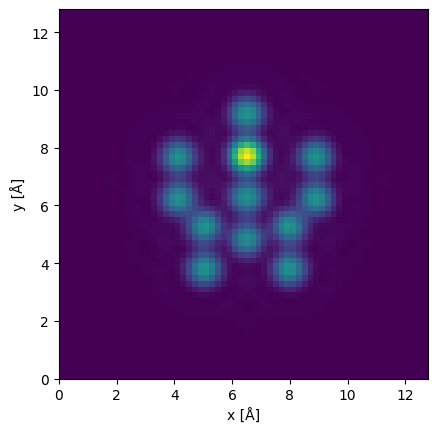

In [20]:
measurements.interpolate(0.2).show()

In [119]:
measurement = s_matrix.scan(detectors=detector, lazy=False)

[########################################] | 100% Completed | 18.43 ss


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

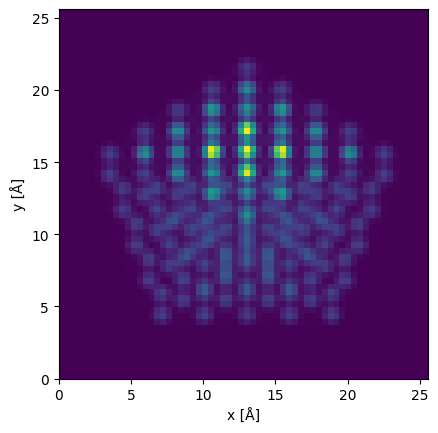

In [120]:
measurement.show()

In [161]:
# p = abtem.Probe(gpts=(62, 128), extent=20, energy=100e3, semiangle_cutoff=10, defocus=[0,10]).build(
#    lazy=False
# )  # .show()#.compute()

In [162]:
p[None]

In [121]:
# waves = s_matrix.dummy_probes().multislice(potential).compute()

In [123]:
# s_matrix.build(lazy=True).array

dask.array<wrapped_build_s_matrix, shape=(177, 342, 342), dtype=complex64, chunksize=(61, 342, 342), chunktype=numpy.ndarray>

In [126]:
measurement = s_matrix.scan(detectors=detector)

with abtem.config.set({"fft": "fftw", "fftw.threads": 2}):
    measurement, (profiler, resource_profiler) = measurement.compute(
        profiler=True, resource_profiler=True, num_workers=4, threads_per_worker=1
    )

[##                                      ] | 5% Completed | 3.60 s ms


NotImplementedError: 

In [21]:
# defaultdict = {}
# for result in profiler.results:
#    #print(result.end_time - result.start_time)
#    print(result.tsk)

In [31]:
row(children=[profiler.visualize(), resource_profiler.visualize()])

Row(id='1566', ...)

In [59]:
peak_memory = max([result.mem for result in resource_profiler.results])
peak_memory

5791.936512

In [55]:
cpu_usage = [result.cpu for result in resource_profiler.results]
peak_cpu_usage = max(cpu_usage)
mean_cpu_usage = np.mean(cpu_usage)

print(peak_cpu_usage, mean_cpu_usage)

737.6 471.30000000000007


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

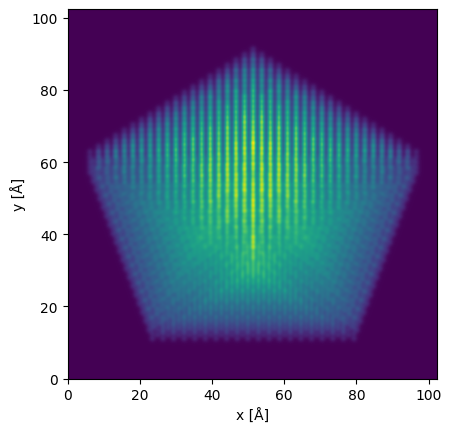

In [13]:
measurement.gaussian_filter(0.5).interpolate(0.1).show()